**Deep Learning**

**Practice 3.1 - VAE**

**Marcelo Ferrer - Aymen Merchaoui**


## 1. Imports, declarations and configuration

In this section we define the necessary imports, declarations and configuration to run the application. 

In [1]:
# Verify that GPU is active
import tensorflow as tf

gpu_active = tf.config.list_physical_devices('GPU')

if (len(gpu_active) == 0):
    print("NO GPU ACTIVE!!!")
else:
    print("Using GPU")

NO GPU ACTIVE!!!


In [2]:
import numpy as np
import glob, os
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [3]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

Load the images

In [4]:
DATA_FOLDER = "dataset/img_align_celeba/"
WEIGHTS_FOLDER = 'dataset/weights/'

if not os.path.exists(WEIGHTS_FOLDER):
    os.makedirs(os.path.join(WEIGHTS_FOLDER,"AE"))
    os.makedirs(os.path.join(WEIGHTS_FOLDER,"VAE"))

filenames = np.array(glob.glob(os.path.join(DATA_FOLDER, '*/*.jpg')))
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))

Total number of images : 202599


In [5]:
INPUT_DIM = (16,16,3) # Image dimension
BATCH_SIZE = 64
Z_DIM = 100 # Dimension of the latent vector (z)

data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(DATA_FOLDER, 
    target_size = INPUT_DIM[:2],
    batch_size = BATCH_SIZE,
    shuffle = True,
    class_mode = 'input',
    subset = 'training'
    )

Found 202599 images belonging to 1 classes.


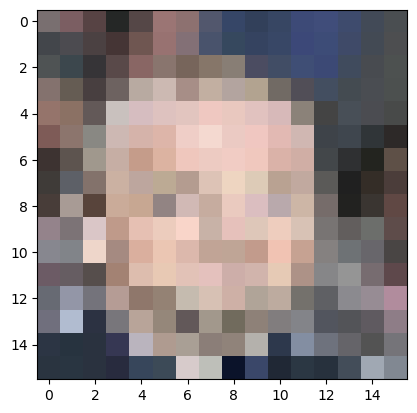

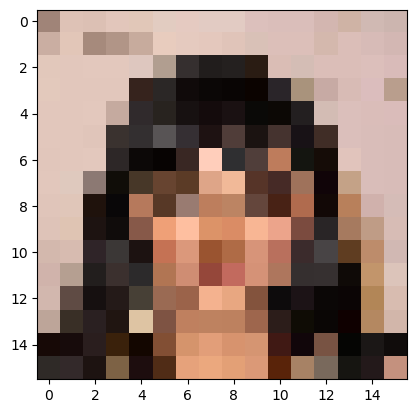

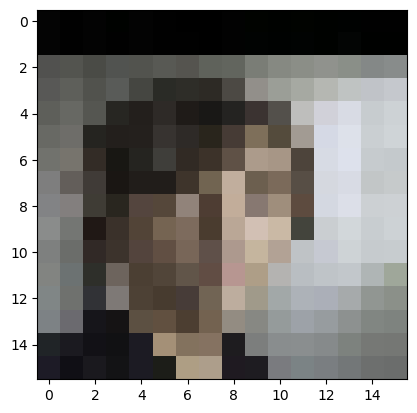

In [6]:
batch = data_flow.next()
for i in range(0,3):
    image = batch[0][i]
    plt.imshow(image)
    plt.show()

In [7]:
from keras.utils.vis_utils import plot_model
 
# ENCODER
def build_vae_encoder(input_dim, output_dim, conv_filters, conv_kernel_size, conv_strides):
  
    # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu, 
    # BatchNormalization and Dropout.
    # Otherwise, the names of above mentioned layers in the model 
    # would be inconsistent
    global K
    K.clear_session()
    
    # Number of Conv layers
    n_layers = len(conv_filters)

    # Define model input
    encoder_input = Input(shape = input_dim, name = 'encoder_input')
    x = encoder_input

    # Add convolutional layers
    for i in range(n_layers):
        x = Conv2D(filters = conv_filters[i], 
            kernel_size = conv_kernel_size[i],
            strides = conv_strides[i], 
            padding = 'same',
            name = 'encoder_conv_' + str(i)
            )(x)

        x = LeakyReLU()(x)
        
    # Required for reshaping latent vector while building Decoder
    shape_before_flattening = K.int_shape(x)[1:] 
    
    x = Flatten()(x)
    mean_mu = Dense(output_dim, name = 'mu')(x)
    log_var = Dense(output_dim, name = 'log_var')(x)

    # Defining a function for sampling
    def sampling(args):
        mean_mu, log_var = args
        epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
        return mean_mu + K.exp(log_var/2)*epsilon   

    # Using a Keras Lambda Layer to include the sampling function as a layer 
    # in the model
    encoder_output = Lambda(sampling, name='encoder_output')([mean_mu, log_var])


    return encoder_input, encoder_output, mean_mu, log_var, shape_before_flattening, Model(encoder_input, encoder_output)


vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_shape_before_flattening, vae_encoder  = build_vae_encoder(
    input_dim = INPUT_DIM,
    output_dim = Z_DIM, 
    conv_filters = [32, 64, 64, 64],
    conv_kernel_size = [3,3,3,3],
    conv_strides = [2,2,2,2])

vae_encoder.summary()

plot_model(vae_encoder, show_shapes=True, show_layer_names=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 16, 16, 3)]  0           []                               
                                                                                                  
 encoder_conv_0 (Conv2D)        (None, 8, 8, 32)     896         ['encoder_input[0][0]']          
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 8, 8, 32)     0           ['encoder_conv_0[0][0]']         
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 4, 4, 64)     18496       ['leaky_re_lu[0][0]']            
                                                                                              

In [8]:
# Decoder
def build_decoder(input_dim, shape_before_flattening, conv_filters, conv_kernel_size, conv_strides):

    # Number of Conv layers
    n_layers = len(conv_filters)

    # Define model input
    decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')

    # To get an exact mirror image of the encoder
    x = Dense(np.prod(shape_before_flattening))(decoder_input)
    x = Reshape(shape_before_flattening)(x)

    # Add convolutional layers
    for i in range(n_layers):
        x = Conv2DTranspose(
            filters = conv_filters[i], 
            kernel_size = conv_kernel_size[i],
            strides = conv_strides[i], 
            padding = 'same',
            name = 'decoder_conv_' + str(i)
            )(x)
        
        # Adding a sigmoid layer at the end to restrict the outputs 
        # between 0 and 1
        if i < n_layers - 1:
            x = LeakyReLU()(x)
        else:
            x = Activation('sigmoid')(x)

    # Define model output
    decoder_output = x

    return decoder_input, decoder_output, Model(decoder_input, decoder_output)

decoder_input, decoder_output, vae_decoder = build_decoder(input_dim = Z_DIM,
    shape_before_flattening = vae_shape_before_flattening,
    conv_filters = [64,64,32,3],        
    conv_kernel_size = [3,3,3,3],
    conv_strides = [2,2,2,2]
    )

vae_decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 64)                6464      
                                                                 
 reshape (Reshape)           (None, 1, 1, 64)          0         
                                                                 
 decoder_conv_0 (Conv2DTrans  (None, 2, 2, 64)         36928     
 pose)                                                           
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 2, 2, 64)          0         
                                                                 
 decoder_conv_1 (Conv2DTrans  (None, 4, 4, 64)         36928     
 pose)                                                     

In [9]:
vae_input = vae_encoder_input
vae_output = vae_decoder(vae_encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
vae = Model(vae_input, vae_output)

vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 16, 16, 3)]  0           []                               
                                                                                                  
 encoder_conv_0 (Conv2D)        (None, 8, 8, 32)     896         ['encoder_input[0][0]']          
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 8, 8, 32)     0           ['encoder_conv_0[0][0]']         
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 4, 4, 64)     18496       ['leaky_re_lu[0][0]']            
                                                                                            

In [10]:
LEARNING_RATE = 0.0005
N_EPOCHS = 200
LOSS_FACTOR = 10000

adam_optimizer = Adam(learning_rate = LEARNING_RATE)

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

def kl_loss(y_true, y_pred):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean_mu) - K.exp(log_var), axis = 1)
    return kl_loss

def total_loss(y_true, y_pred):
    return LOSS_FACTOR*r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

vae.compile(optimizer=adam_optimizer, loss = total_loss, metrics = [r_loss, kl_loss])

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

vae.fit(data_flow, 
    shuffle=True, 
    epochs = N_EPOCHS, 
    initial_epoch = 0, 
    steps_per_epoch=NUM_IMAGES / BATCH_SIZE)

vae.save(os.path.join(WEIGHTS_FOLDER, 'VAE/model.h5'))

Epoch 1/200


TypeError: in user code:

    File "c:\Users\marce\miniconda3\envs\gpu_dl\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\marce\miniconda3\envs\gpu_dl\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\marce\miniconda3\envs\gpu_dl\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\marce\miniconda3\envs\gpu_dl\lib\site-packages\keras\engine\training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\marce\miniconda3\envs\gpu_dl\lib\site-packages\keras\engine\training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "c:\Users\marce\miniconda3\envs\gpu_dl\lib\site-packages\keras\engine\compile_utils.py", line 239, in __call__
        self._loss_metric.update_state(
    File "c:\Users\marce\miniconda3\envs\gpu_dl\lib\site-packages\keras\utils\metrics_utils.py", line 70, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "c:\Users\marce\miniconda3\envs\gpu_dl\lib\site-packages\keras\metrics\base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "c:\Users\marce\miniconda3\envs\gpu_dl\lib\site-packages\keras\metrics\base_metric.py", line 449, in update_state  **
        sample_weight = tf.__internal__.ops.broadcast_weights(
    File "c:\Users\marce\miniconda3\envs\gpu_dl\lib\site-packages\keras\engine\keras_tensor.py", line 254, in __array__
        raise TypeError(

    TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='Placeholder:0', description="created by layer 'tf.cast_2'"), an intermediate Keras symbolic input/output, to a TF API that does not allow registering custom dispatchers, such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. Keras Functional model construction only supports TF API calls that *do* support dispatching, such as `tf.math.add` or `tf.reshape`. Other APIs cannot be called directly on symbolic Kerasinputs/outputs. You can work around this limitation by putting the operation in a custom Keras layer `call` and calling that layer on this symbolic input/output.


In [ ]:
def r_loss(y_true, y_pred):
        return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

def kl_loss(y_true, y_pred):
        kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean_mu) - K.exp(log_var), axis = 1)
        return kl_loss

def total_loss(y_true, y_pred):
        return LOSS_FACTOR*r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)


VAE = tensorflow.keras.models.load_model(os.path.join(WEIGHTS_FOLDER, 'VAE/model.h5'),
    custom_objects={"r_loss": r_loss, "kl_loss": kl_loss, "total_loss": total_loss })
#VAE.summary()


VAE_encoder_input = Input(shape = INPUT_DIM, name = 'VAE_encoder_input')
x = VAE_encoder_input
for i in range(1, 9):
        x = VAE.layers[i](x)
x = Flatten()(x)
mean_mu = VAE.layers[10](x)
log_var = VAE.layers[11](x)

# Defining a function for sampling
def sampling(args):
    mean_mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
    return mean_mu + K.exp(log_var/2)*epsilon   

# Using a Keras Lambda Layer to include the sampling function as a layer 
# in the model
VAE_encoder_output = Lambda(sampling, name='VAE_encoder_output')([mean_mu, log_var])
VAE_encoder=Model(VAE_encoder_input, VAE_encoder_output)
VAE_encoder.summary()


VAE_decoder = tensorflow.keras.Sequential()
VAE_decoder.add(VAE.layers[-1])
VAE_decoder.build()
VAE_decoder.summary()

In [ ]:
def VAE_generate_images_from_noise(n_to_show = 8): 
    reconst_images = VAE_decoder.predict(np.random.normal(0,1,size=(n_to_show,Z_DIM)))

    fig = plt.figure(figsize=(12, 3))
    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, hspace=0.1, wspace=0.1)

    for i in range(n_to_show):
            img = reconst_images[i].squeeze()
            sub = fig.add_subplot(1, n_to_show, i+1)
            sub.axis('off')        
            sub.imshow(img)
    plt.show()

VAE_generate_images_from_noise()  